In [1]:
%matplotlib inline


In [3]:
import pandas as pd       # Data handling (e.g., price data, returns)
import numpy as np        # Numerical operations (e.g., mean, standard deviation)
import backtrader as bt  # Full-featured backtesting framework
from finta import TA    # Technical Analysis library (e.g., moving averages, RSI)
import QuantLib as ql   # Quantitative finance models, pricing, and calculations


In [4]:
import matplotlib.pyplot as plt   # Plotting results like returns or drawdowns
import seaborn as sns             # Enhanced visualizations (optional)
from scipy.stats import norm      # Used for probability calculations in finance
import quantstats
import riskfolio as rp


In [5]:
import yfinance as yf
aapl_data = yf.download("AAPL", start="2020-01-01", end="2023-01-01")
aapl_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.796028,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.088295,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.662720,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.320969,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.484352,132079200
...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,130.487808,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,128.676834,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,124.728371,85438400


In [6]:
aapl_data['SMA_20']= aapl_data['Close'].rolling(window=20).mean()
aapl_data['Std_20']=aapl_data['Close'].rolling(window=20).std()
aapl_data['Upper_band']=aapl_data['SMA_20']+aapl_data['Std_20']
aapl_data['Lower_band']=aapl_data['SMA_20']-aapl_data['Std_20']

In [7]:
#np.where(condition, value_if_true, value_if_false): This function checks the specified condition and assigns a value based on whether 
#the condition is True or False.

aapl_data['Buy_Signal']= np.where(aapl_data['Close']<aapl_data['Lower_band'],1,0)

In [8]:
aapl_data['Sell_Signal']= np.where(aapl_data['Close']>aapl_data['Upper_band'],-1,0)

In [9]:
# 1 is buy, -1 is sell, 0 is hold

aapl_data['Position']= aapl_data['Buy_Signal']+ aapl_data['Sell_Signal']

In [10]:
aapl_data['Position'] = aapl_data['Position'].replace(0, np.nan).ffill().fillna(0)
aapl_data['Daily_returns']=aapl_data['Close'].pct_change()

In [11]:
'''Here, what we are doing is we calculate return of the strategy as the position we hold today multiplied by yesterdays's returns. 
So if we sold yesterday position would be 0 so no profit or loss but if we bought(thats 1) we would have some profit or loss. 
If its -1 we basically subtract the returns we would have made if we still held the stock on that day.This is to determine the effectiveness
of the strategy.

​STRATEGY RETURNS(t) = POSITION(t-1)*DAILY_RETURNS(t)

DAILY RETURNS(t) means the percentage change from end of day(t-1) to day(t)

'''
aapl_data['Strategy_Returns']=aapl_data['Position'].shift(1)*aapl_data['Daily_returns']

In [12]:
#For Cumulative Returns-
'''
(1 + aapl['Strategy_Returns'])- This is to create a multiplicative factor to determine the effect on the portfolio
.cumprod() - This is a function that'll help calculate the cumulative multiplications
The way this works if- You calculate returns for each day and basically keep multiplying one after the other
'''

aapl_data['Cumulative_Strategy_Returns']= (1 + aapl_data['Strategy_Returns']).cumprod()

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,17))

<Figure size 1400x1700 with 0 Axes>

<Figure size 1400x1700 with 0 Axes>

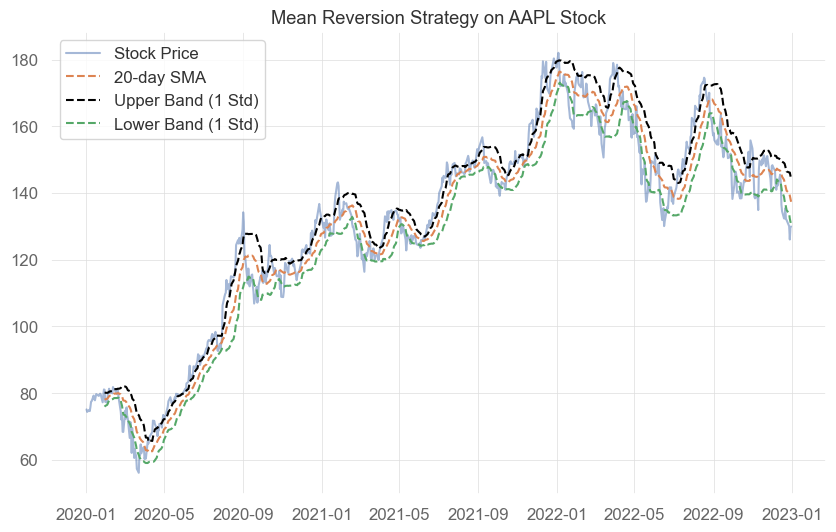

In [14]:
plt.plot(aapl_data['Close'], label='Stock Price', alpha=0.5)
plt.plot(aapl_data['SMA_20'], label='20-day SMA', linestyle='--')
plt.plot(aapl_data['Upper_band'], label='Upper Band (1 Std)', linestyle='--',color='black')
plt.plot(aapl_data['Lower_band'], label='Lower Band (1 Std)', linestyle='--')
plt.legend()
plt.title('Mean Reversion Strategy on AAPL Stock')
plt.show()

In [15]:
import backtrader as bt

In [16]:
aapl_bt_data = yf.download('AAPL', start='2016-01-01', end='2020-01-01')
aapl_bt_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,25.652500,26.342501,25.500000,26.337500,23.860580,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.262651,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,22.807402,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,21.844831,324377600
2016-01-08,24.637501,24.777500,24.190001,24.240000,21.960339,283192000
...,...,...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497,68.898682,48478800
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.265678,93121200
2019-12-27,72.779999,73.492500,72.029999,72.449997,70.238991,146266000


In [17]:
class Strategy(bt.Strategy):
    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(self.data.close, period=20)
        self.stddev = bt.indicators.StandardDeviation(self.data.close, period=20)
        self.upper_band= self.sma + self.stddev
        self.lower_band= self.sma - self.stddev

    def next(self):

        if self.data.close[0] < self.lower_band[0]:
            if not self.position:
                self.buy()
    
        elif self.data.close[0] > self.upper_band[0]:
            if self.position:
                self.sell()

            

In [18]:
# Convert the pandas DataFrame into Backtrader data
data_feed = bt.feeds.PandasData(dataname=aapl_bt_data)

In [19]:
# Set up the backtest engine (Cerebro)
cerebro = bt.Cerebro()

# Add the data feed and the strategy
cerebro.adddata(data_feed)
cerebro.addstrategy(Strategy)


0

<IPython.core.display.Javascript object>

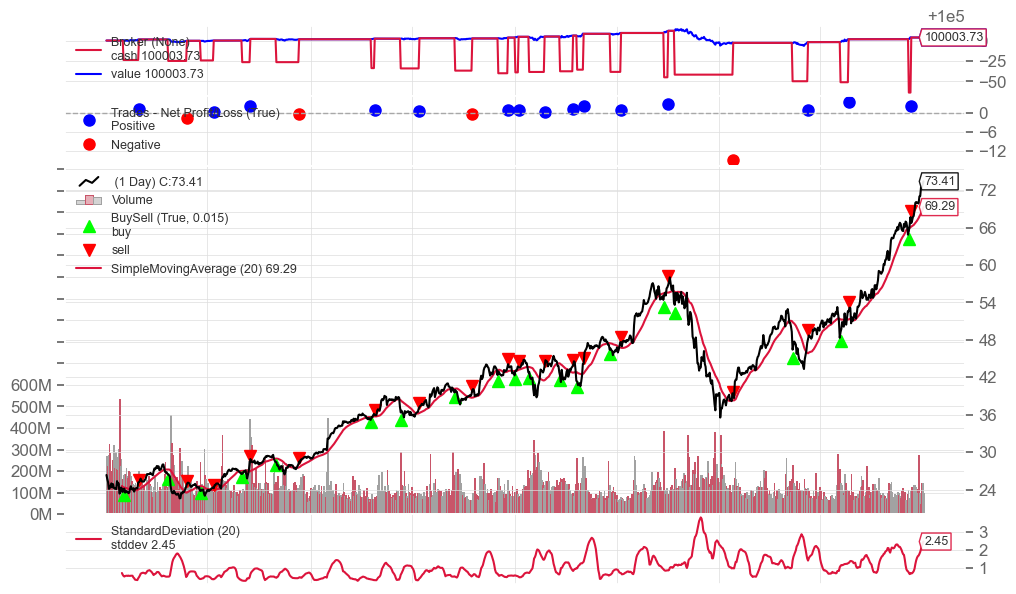

In [20]:
cerebro.broker.setcash(100000)  # Initial cash
cerebro.broker.setcommission(commission=0.001)  # Commission per trade

# Run the backtest
cerebro.run()

import matplotlib.pyplot as plt

# After running cerebro.run()
%matplotlib inline
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
cerebro.plot()
plt.show()

In [21]:
final_cash = cerebro.broker.get_cash()
print(f"Final cash value: {final_cash}")

Final cash value: 100003.7332419758


In [22]:
import yfinance as yf

# Download 1-minute data for AAPL (data starts from 2020-01-01)
aapl_data2 = yf.download('AAPL', start='2024-11-29', end='2024-12-07', interval='1m')


[*********************100%%**********************]  1 of 1 completed


In [23]:
# Convert the pandas DataFrame into Backtrader data
data_feed = bt.feeds.PandasData(dataname=aapl_data2)

In [24]:
# Set up the backtest engine (Cerebro)
cerebro = bt.Cerebro()

# Add the data feed and the strategy
cerebro.adddata(data_feed)
cerebro.addstrategy(Strategy)


0

<IPython.core.display.Javascript object>

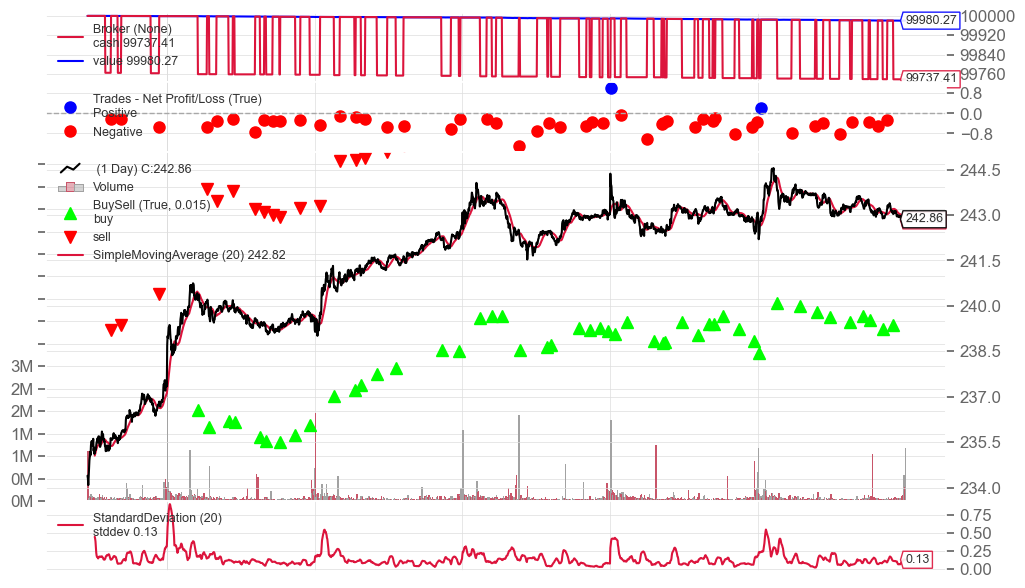

In [25]:
cerebro.broker.setcash(100000)  # Initial cash
cerebro.broker.setcommission(commission=0.001)  # Commission per trade

# Run the backtest
cerebro.run()

import matplotlib.pyplot as plt

# After running cerebro.run()
%matplotlib inline
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
cerebro.plot()
plt.show()

In [26]:
import backtrader as bt
import yfinance as yf

class MeanReversionStrategy(bt.Strategy):
    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(self.data.close, period=20)
        self.std = bt.indicators.StandardDeviation(self.data.close, period=20)
        self.upper_band = self.sma + self.std
        self.lower_band = self.sma - self.std

        self.trade_count = 0
        self.trade_dates = []

    def next(self):
        if not self.position:  
            if self.data.close[0] < self.lower_band[0]:
                self.buy()  
        elif self.data.close[0] > self.upper_band[0]: 
            self.sell()

    def notify_trade(self, trade):
        if trade.isclosed:
            self.trade_count += 1
            self.trade_dates.append(self.data.datetime.date(0))  
            print(f"Trade {self.trade_count}: Profit {trade.pnl}, Net Profit {trade.pnlcomm}")

    def stop(self):
        print(f"Total Trades: {self.trade_count}")
        if len(self.trade_dates) > 1:
            intervals = [
                (self.trade_dates[i] - self.trade_dates[i - 1]).days
                for i in range(1, len(self.trade_dates))
            ]
            print(f"Average Trade Interval: {sum(intervals) / len(intervals):.2f} days")
        else:
            print("Not enough trades to calculate intervals.")

# Fetch historical data


In [45]:
data = bt.feeds.PandasData(dataname=yf.download('AAPL', start='2020-01-01', end='2021-01-01'))

cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(MeanReversionStrategy)
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')

cerebro.broker.set_cash(100000)
cerebro.broker.setcommission(commission=0.001)

results = cerebro.run()

trade_analyzer = results[0].analyzers.trade_analyzer
print("\nTrade Analyzer Results:")
print(f"Total Closed Trades: {trade_analyzer.get_analysis().total.closed}")
print(f"Winning Trades: {trade_analyzer.get_analysis().won.total}")
print(f"Losing Trades: {trade_analyzer.get_analysis().lost.total}")

final_cash=cerebro.broker.get_cash()
final_cash

[*********************100%%**********************]  1 of 1 completed

Trade 1: Profit -7.1399993896484375, Net Profit -7.281489395141602
Trade 2: Profit -1.5600051879882812, Net Profit -1.7929651870727539
Trade 3: Profit 7.25, Net Profit 7.018009994506836
Total Trades: 3
Average Trade Interval: 108.50 days

Trade Analyzer Results:
Total Closed Trades: 3
Winning Trades: 1
Losing Trades: 2


99997.94355541229

<IPython.core.display.Javascript object>

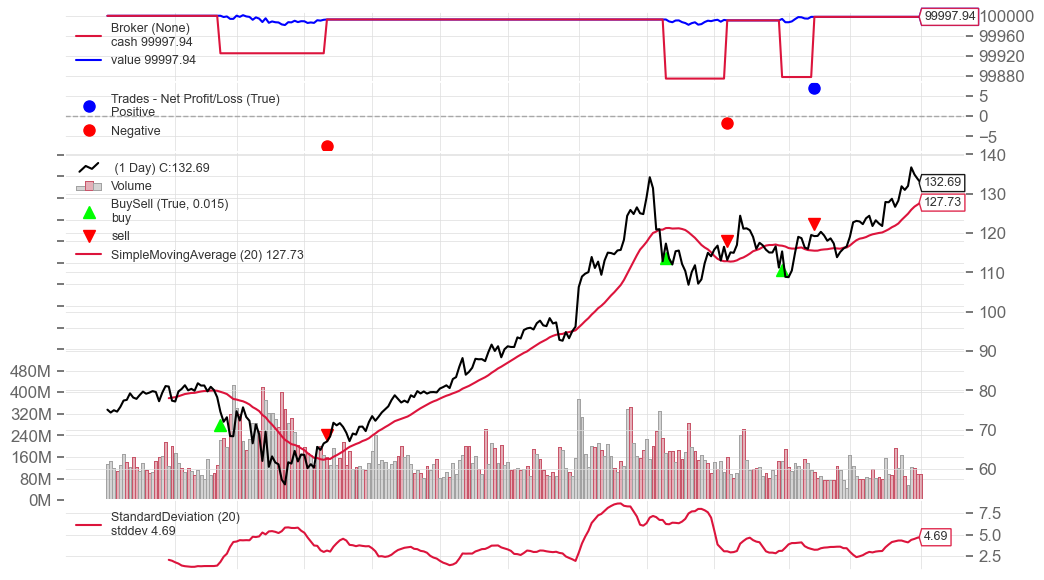

In [30]:
%matplotlib inline
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
cerebro.plot()
plt.show()

In [44]:
data = bt.feeds.PandasData(dataname=yf.download('AAPL', start='2024-11-29', end='2024-12-07', interval='1m'))

cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(MeanReversionStrategy)
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')

cerebro.broker.set_cash(100000)
cerebro.broker.setcommission(commission=0.001)

results = cerebro.run()

trade_analyzer = results[0].analyzers.trade_analyzer
print("\nTrade Analyzer Results:")
print(f"Total Closed Trades: {trade_analyzer.get_analysis().total.closed}")
print(f"Winning Trades: {trade_analyzer.get_analysis().won.total}")
print(f"Losing Trades: {trade_analyzer.get_analysis().lost.total}")

final_cash=cerebro.broker.get_cash()
final_cash

[*********************100%%**********************]  1 of 1 completed

Trade 1: Profit 0.25, Net Profit -0.22098999023437504
Trade 2: Profit 0.25, Net Profit -0.22125000000000006
Trade 3: Profit -0.0500030517578125, Net Profit -0.5236230621337891
Trade 4: Profit -0.07000732421875, Net Profit -0.5503173217773438
Trade 5: Profit 0.160003662109375, Net Profit -0.3194563293457031
Trade 6: Profit 0.2599945068359375, Net Profit -0.21992549133300782
Trade 7: Profit -0.250091552734375, Net Profit -0.729521453857422
Trade 8: Profit 0.1999969482421875, Net Profit -0.2787430572509766
Trade 9: Profit 0.19000244140625, Net Profit -0.28850756835937497
Trade 10: Profit 0.1699981689453125, Net Profit -0.3084818267822266
Trade 11: Profit 0.220001220703125, Net Profit -0.25901876831054693
Trade 12: Profit 0.019989013671875, Net Profit -0.4593509826660156
Trade 13: Profit 0.3799896240234375, Net Profit -0.10187037658691411
Trade 14: Profit 0.3397979736328125, Net Profit -0.14223222351074222
Trade 15: Profit 0.25, Net Profit -0.23224999999999996
Trade 16: Profit -0.055007934

99737.40911053465

<IPython.core.display.Javascript object>

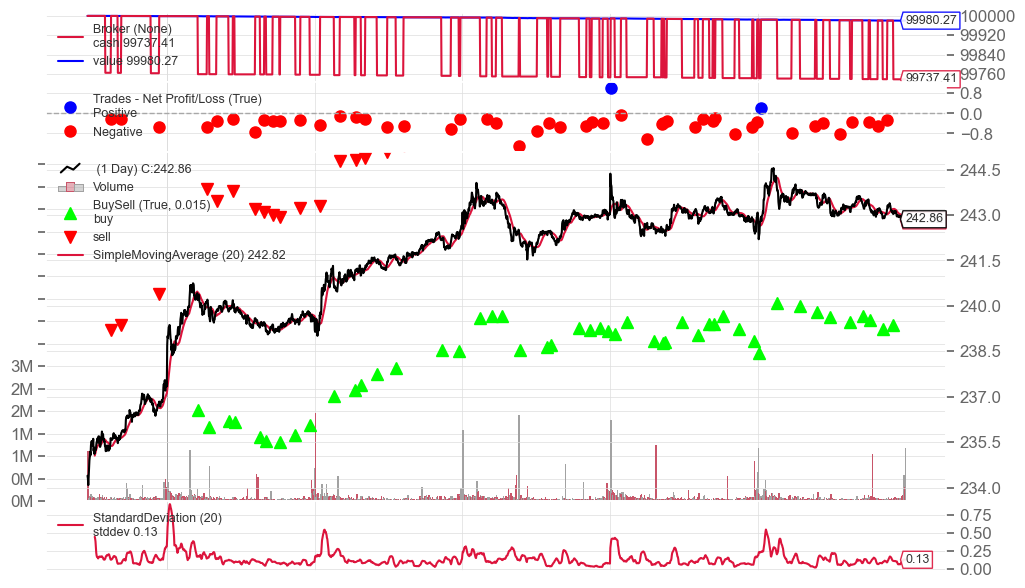

In [32]:
%matplotlib inline
plt.figure(figsize=(10, 6)) 
cerebro.plot()
plt.show()

In [41]:
data = bt.feeds.PandasData(dataname=yf.download('AAPL', start='2024-1-29', end='2024-12-07', interval='1h'))

cerebro=bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(MeanReversionStrategy)
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')

cerebro.broker.set_cash(100000)
cerebro.broker.setcommission(commission=0.001)

results = cerebro.run()

trade_analyzer = results[0].analyzers.trade_analyzer
print("\nTrade Analyzer Results:")
print(f"Total Closed Trades: {trade_analyzer.get_analysis().total.closed}")
print(f"Winning Trades: {trade_analyzer.get_analysis().won.total}")
print(f"Losing Trades: {trade_analyzer.get_analysis().lost.total}")

[*********************100%%**********************]  1 of 1 completed

Trade 1: Profit 1.7299957275390625, Net Profit 1.3572257232666016
Trade 2: Profit 1.78839111328125, Net Profit 1.4110027160644532
Trade 3: Profit -4.410003662109375, Net Profit -4.780533660888672
Trade 4: Profit -9.830001831054688, Net Profit -10.183391830444336
Trade 5: Profit 2.68499755859375, Net Profit 2.340342559814453
Trade 6: Profit 6.75189208984375, Net Profit 6.403903991699218
Trade 7: Profit -0.3600006103515625, Net Profit -0.7052806243896484
Trade 8: Profit 0.925994873046875, Net Profit 0.5848908691406249
Trade 9: Profit 0.4199981689453125, Net Profit 0.0805781707763672
Trade 10: Profit -4.3600006103515625, Net Profit -4.698040603637695
Trade 11: Profit 14.199005126953125, Net Profit 13.844806121826172
Trade 12: Profit 1.035003662109375, Net Profit 0.6527786560058594
Trade 13: Profit 2.589996337890625, Net Profit 2.2066263427734376
Trade 14: Profit 1.6999969482421875, Net Profit 1.3089769439697265
Trade 15: Profit 7.7425079345703125, Net Profit 7.348465438842774
Trade 16: Pr

In [42]:
final_cash = cerebro.broker.get_cash()
final_cash

100035.21230473324

In [43]:

# Get final portfolio value
final_value = cerebro.broker.get_value()
print(f"Final Portfolio Value: ${final_value:.2f}")


Final Portfolio Value: $100035.21
